In [1]:
import gcsfs
import os.path as op

In [2]:
fs = gcsfs.GCSFileSystem(project='learning-2-learn-221016', token="cloud")

In [3]:
fs = gcsfs.GCSFileSystem(project='learning-2-learn-221016', token=fs.session.credentials)

In [4]:
metadata_file = '2017_5_04_raw.json'
if not op.exists(metadata_file):
    fs.get(op.join('learning2learn/Buffalo/NWB-experiments/', metadata_file), metadata_file)    

In [5]:
import json
from hdf5zarr import NWBZARRHDF5IO, HDF5Zarr

# import metadata from a json file
with open(metadata_file, 'r') as mfile:
    store = json.load(mfile)

f = fs.open('learning2learn/Buffalo/NWB-experiments/2017_5_04_raw.nwb', 'rb')

hdf5_zarr = HDF5Zarr(f, store = store, store_mode = 'r')
zgroup = hdf5_zarr.zgroup
io = NWBZARRHDF5IO(mode='r', file=zgroup, load_namespaces=True)
nwb = io.read()


/srv/conda/envs/notebook/lib/python3.7/site-packages/hdmf/spec/namespace.py:470: UserWarning: ignoring namespace 'hdmf-common' because it already exists
  warn("ignoring namespace '%s' because it already exists" % ns['name'])
/srv/conda/envs/notebook/lib/python3.7/site-packages/hdmf/spec/namespace.py:470: UserWarning: ignoring namespace 'core' because it already exists
  warn("ignoring namespace '%s' because it already exists" % ns['name'])


In [6]:
fs = nwb.acquisition['ElectricalSeries'].rate

In [7]:
fs

32000.0

In [8]:
print(zgroup.tree())

/
 ├── acquisition
 │   └── ElectricalSeries
 │       ├── data (275057279, 124) int16
 │       ├── electrodes (124,) int64
 │       └── starting_time () float64
 ├── analysis
 ├── file_create_date (1,) object
 ├── general
 │   ├── devices
 │   │   └── Device
 │   ├── experimenter (1,) object
 │   ├── extracellular_ephys
 │   │   ├── ElectrodeGroup
 │   │   │   └── device
 │   │   │       └── .link
 │   │   └── electrodes
 │   │       ├── filtering (124,) object
 │   │       ├── group (124,) uint64
 │   │       ├── group_name (124,) object
 │   │       ├── id (124,) int64
 │   │       ├── imp (124,) float64
 │   │       ├── label (124,) object
 │   │       ├── location (124,) object
 │   │       ├── x (124,) float64
 │   │       ├── y (124,) float64
 │   │       └── z (124,) float64
 │   ├── institution () object
 │   ├── keywords (3,) object
 │   ├── lab () object
 │   ├── notes () object
 │   └── source_script () object
 ├── identifier () object
 ├── processing
 ├── session_descriptio

In [9]:
data = zgroup['acquisition/ElectricalSeries/data']

In [10]:
import matplotlib.pyplot as plt
import numpy as np

In [11]:
import dask.array as da

In [12]:
arr = da.from_zarr(data)
arr = arr.T  # We want channels as rows
arr = arr[np.newaxis] # We need an epochs dimension

In [13]:
arr.shape

(1, 124, 275057279)

In [14]:
import ipywidgets as widgets

In [15]:
import matplotlib.pyplot as plt
import numpy as np

In [16]:
chan = widgets.SelectMultiple(
    options=np.arange(arr.shape[1]),
    value=[0],
    description='Channels:',
    disabled=False
    
)

time = widgets.IntSlider(
    value=0,
    min=0,
    max=arr.shape[-1]-5000,
    step=1,
    description='Starting timepoint:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
)

time_d = widgets.IntSlider(
    value=5000,
    min=0,
    max=10000,
    step=1,
    description='Window duration',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
)



def f(time, time_d=5000, chan=[0]):
    fig, ax = plt.subplots()
    for c in chan:
        if c < 124:
            ax.plot(arr[0, c, time:time+time_d], label=f"Channel {c}")
    ax.legend()
    ax.set_xlabel("Time (samples)")
    ax.set_ylabel("Voltage")
    plt.show()

out = widgets.interactive_output(f, {'chan': chan, 'time': time, 'time_d': time_d})

widgets.HBox([widgets.VBox([chan, time, time_d]), out])

In [17]:
from tools import init_cluster, batch_process

In [19]:
cluster, client = init_cluster(n_workers=40)

In [23]:
cluster

In [24]:
arr.persist()

,Array,Chunk
Bytes,68.21 GB,537.22 kB
Shape,"(1, 124, 275057279)","(1, 1, 268611)"
Count,126976 Tasks,126976 Chunks
Type,int16,numpy.ndarray


In [25]:
from mne.time_frequency import tfr_array_morlet

In [26]:
from functools import partial

In [52]:
freqs = np.logspace(1, 2, 20)

In [53]:
my_morlet = partial(tfr_array_morlet, sfreq=fs, freqs=freqs)

In [54]:
sample = arr[0, 0, :500000].compute()

In [55]:
sample.shape

(500000,)

In [56]:
result = my_morlet(sample[None, None, :])

In [57]:
result.dtype

dtype('complex128')

In [58]:
result.shape

(1, 1, 20, 500000)

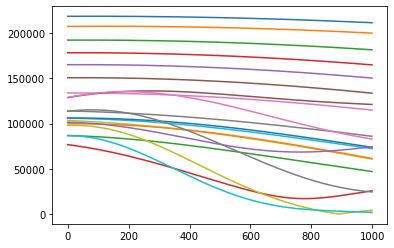

In [59]:
plt.plot(np.abs(result[0, 0, :, :1000].T))

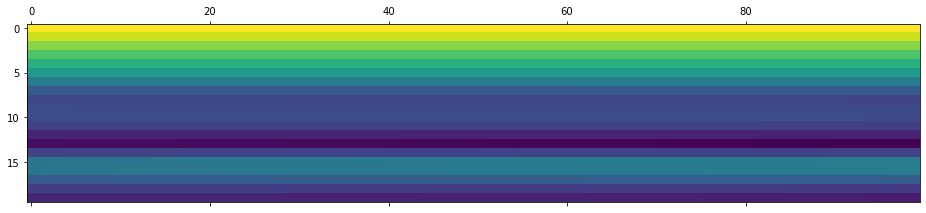

In [60]:
plt.matshow(np.abs(result[0, 0, :, :100]))

In [61]:
morlet_arr = arr.map_blocks(my_morlet, dtype=result.dtype, new_axis=2)

In [62]:
morlet_arr

,Array,Chunk
Bytes,545.71 GB,4.30 MB
Shape,"(1, 124, 1, 275057279)","(1, 1, 1, 268611)"
Count,507905 Tasks,126976 Chunks
Type,complex128,numpy.ndarray


In [63]:
chan = widgets.Select(
    options=np.arange(arr.shape[1]),
    value=[0],
    description='Channel:',
    disabled=False
    
)

time = widgets.IntSlider(
    value=0,
    min=0,
    max=arr.shape[-1]-500,
    step=1,
    description='Starting timepoint:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
)

time_d = widgets.IntSlider(
    value=50,
    min=0,
    max=1000,
    step=1,
    description='Window duration',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
)



def f(time, time_d=5000, chan=0):
    fig, ax = plt.subplots()
    result = np.abs(morlet_arr[0, chan, :, time:time+time_d].compute())
    ax.matshow(result)
    ax.legend()
    ax.set_xlabel("Time (samples)")
    ax.set_ylabel("Frequency (10Hz bins)")
    plt.show()

out = widgets.interactive_output(f, {'chan': chan, 'time': time, 'time_d': time_d})

widgets.HBox([widgets.VBox([chan, time, time_d]), out])

In [64]:
morlet_mean = da.mean(morlet_arr, axis=-1)
morlet_std = da.std(morlet_arr, axis=-1)

/srv/conda/envs/notebook/lib/python3.7/site-packages/numpy/core/_methods.py:47: ComplexWarning: Casting complex values to real discards the imaginary part
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


In [65]:
morlet_mean

,Array,Chunk
Bytes,1.98 kB,16 B
Shape,"(1, 124, 1)","(1, 1, 1)"
Count,677165 Tasks,124 Chunks
Type,complex128,numpy.ndarray


In [66]:
mean_chan = morlet_mean[:, 0, :]

In [67]:
mean_chan

dask.array<getitem, shape=(1, 1), dtype=complex128, chunksize=(1, 1), chunktype=numpy.ndarray>

In [44]:
# from dask.distributed import progress
# mean_chan = mean_chan.persist()  # start computation in the background
# progress(mean_chan)      # watch progress

VBox()

In [68]:
std_chan = morlet_std[:, 0, :]

In [69]:
zscored = (morlet_arr[:,0,:,:] - mean_chan) / std_chan

In [ ]:
from dask.distributed import progress
zscored = zscored.persist()
progress(zscored) 

/srv/conda/envs/notebook/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: ComplexWarning: Casting complex values to real discards the imaginary part
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


In [ ]:
zscored

In [ ]:
zscored[0,:,:100].compute()

In [ ]:
time = widgets.IntSlider(
    value=0,
    min=0,
    max=arr.shape[-1]-500,
    step=1,
    description='Starting timepoint:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
)

time_d = widgets.IntSlider(
    value=50,
    min=0,
    max=1000,
    step=1,
    description='Window duration',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
)



def f(time, time_d=5000):
    fig, ax = plt.subplots()
    result = np.abs(zscored[0, 0, :, time:time+time_d].compute())
    ax.matshow(result)
    ax.legend()
    ax.set_xlabel("Time (samples)")
    ax.set_ylabel("Frequency (10Hz bins)")
    plt.show()

out = widgets.interactive_output(f, {'time': time, 'time_d': time_d})

widgets.HBox([widgets.VBox([time, time_d]), out])

In [38]:
to_save = morlet_arr[0, 0, 0]

In [39]:
import zarr

In [40]:
gcsmap_zarr = gcsfs.GCSMap('learning2learn/test_zarr', gcs=fs)

In [41]:
fs.ls('learning2learn/Buffalo')

['learning2learn/Buffalo/wcst-nhp/',
 'learning2learn/Buffalo/BuffaloLabTestSet/',
 'learning2learn/Buffalo/dataScienceSprint/',
 'learning2learn/Buffalo/NWB-experiments/',
 'learning2learn/Buffalo/SmallRawSet/']

AttributeError: 'NoneType' object has no attribute 'startswith'

In [43]:
zarr_ds = zarr.create(to_save.shape, chunks=to_save.chunks, 
                      dtype=to_save.dtype, store=gcsmap_zarr, overwrite=True)

OSError: Forbidden: https://www.googleapis.com/upload/storage/v1/b/learning2learn/o
Insufficient Permission

In [20]:
from datashader import transfer_functions as tf, reductions as rd

/srv/conda/envs/notebook/lib/python3.7/site-packages/datashader/transfer_functions.py:21: FutureWarning: xarray subclass Image should explicitly define __slots__
  class Image(xr.DataArray):
